In [1]:
from root_pandas import read_root
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression 
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics.classification import _check_binary_probabilistic_predictions
from sklearn.utils import column_or_1d

import sys
sys.path.append('../')
from scripts.metrics import tagging_power_score
from scripts.calibration import PolynomialLogisticRegression

from uncertainties import ufloat

/opt/rh/miniconda/envs/root_ml_latest/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [3]:
filename = '/fhgfs/groups/e5/lhcb/analysis/FT/NTuples/tmp_os_opt_move_to_OSOptSum17/DTT_2016_Reco16Strip26_20170531_kheinicke_TupleB_predicted-max3pt.root'

In [4]:
totalDf = read_root('/fhgfs/groups/e5/lhcb/analysis/FT/NTuples/tmp_os_opt_move_to_OSOptSum17/DTT_2016_Reco16Strip26_20170529_jwishahi_TupleB_sweights.root',
                    columns=['SigYield_sw', 'nCandidate'], key='Bu2JpsiKDetached')
total_event_number = totalDf[totalDf.nCandidate == 0].SigYield_sw.sum()

In [5]:
total_event_number = ufloat(total_event_number, np.sqrt(total_event_number))

In [6]:
df = read_root(filename)

In [7]:
df.set_index(['runNumber', 'eventNumber', '__array_index'], inplace=True)

In [8]:
calibrationModel = PolynomialLogisticRegression(power=5, solver='lbfgs', n_jobs=24)
calibrationModel.fit(df.probas.values.reshape(-1, 1), df.target)
df['calib_probas'] = calibrationModel.predict_proba(df.probas.values.reshape(-1, 1))[:,1]

In [9]:
isotonicModel = IsotonicRegression()
isotonicModel.fit(df.probas, df.target)
df['isotonic_probas'] = isotonicModel.predict(df.probas)

In [10]:
# steal this from sklearn.calibration

def calibration_curve(y_true, y_prob, normalize=False, bins=10):
    """Compute true and predicted probabilities for a calibration curve.
    Read more in the :ref:`User Guide <calibration>`.
    Parameters
    ----------
    y_true : array, shape (n_samples,)
        True targets.
    y_prob : array, shape (n_samples,)
        Probabilities of the positive class.
    normalize : bool, optional, default=False
        Whether y_prob needs to be normalized into the bin [0, 1], i.e. is not
        a proper probability. If True, the smallest value in y_prob is mapped
        onto 0 and the largest one onto 1.
    n_bins : int
        Number of bins. A bigger number requires more data.
    Returns
    -------
    prob_true : array, shape (n_bins,)
        The true probability in each bin (fraction of positives).
    prob_pred : array, shape (n_bins,)
        The mean predicted probability in each bin.
    References
    ----------
    Alexandru Niculescu-Mizil and Rich Caruana (2005) Predicting Good
    Probabilities With Supervised Learning, in Proceedings of the 22nd
    International Conference on Machine Learning (ICML).
    See section 4 (Qualitative Analysis of Predictions).
    """
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)

    if normalize:  # Normalize predicted values into interval [0, 1]
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    elif y_prob.min() < 0 or y_prob.max() > 1:
        raise ValueError("y_prob has values outside [0, 1] and normalize is "
                         "set to False.")

    y_true = _check_binary_probabilistic_predictions(y_true, y_prob)

    if type(bins) is int:
        bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
        
    binids = np.digitize(y_prob, bins) - 1

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = (bin_true[nonzero] / bin_total[nonzero])
    prob_pred = (bin_sums[nonzero] / bin_total[nonzero])

    return prob_true, prob_pred

In [11]:
# just for comparison, this function misbehaves
def proba_bins(x, y_true, errs=True, bins=10, range=None, sample_weight=None, auto_fill=False):
    """ Bin data by x and calculate the amount of y_true in each bin,
        errors will be (bin_width/2, sqrt(bin_count))
    """
    if sample_weight is None:
        sample_weight = np.ones(x.shape)

    hist, bin_edges = np.histogram(x, bins=bins, range=range)
    xs = np.array([(x_low + x_high)/2 for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
    true_sums = np.array([np.sum(sample_weight[(x > x_low) & (x <= x_high)])
                          for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
    ys = (np.array([np.sum(sample_weight[(x > x_low) & (x <= x_high) & (np.array(y_true) == True)])
                    for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
          / true_sums)
    if errs:
        y_errs = (np.array([np.sqrt(np.sum(sample_weight[(x > x_low) & (x <= x_high) & (np.array(y_true) == False)]))
                            for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
                  / true_sums)
        x_errs = [(x_high - x_low) / 2 for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])]
        return xs, ys, y_errs, x_errs
    else:
        return xs, ys

In [12]:
df['etas'] = np.where(df.probas > 0.5, 1 - df.probas, df.probas)
df['calib_etas'] = np.where(df.calib_probas > 0.5, 1 - df.calib_probas, df.calib_probas)

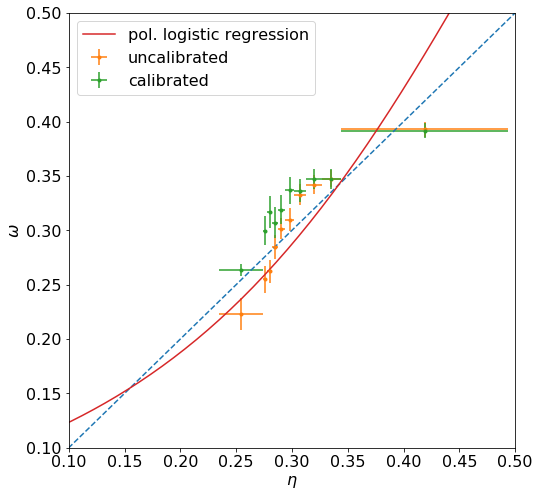

In [13]:
plt.rc('font', size=16)
plt.figure(figsize=(8, 8))
plt.plot([0, 1], '--')
xs = np.linspace(0, 0.5)
ys = calibrationModel.predict_proba(xs.reshape(-1, 1))[:, 1]
# plt.plot(xs, ys, label='logistic regression')
plt.errorbar(*proba_bins(df.etas, df.target,
                         sample_weight=df.SigYield_sw,
                         auto_fill=True, bins=np.percentile(df.etas, np.linspace(0, 100, 11))
                        ), fmt='.', label='uncalibrated')
plt.errorbar(*proba_bins(df.calib_etas, df.target,
                         sample_weight=df.SigYield_sw,
                         auto_fill=True, bins=np.percentile(df.etas, np.linspace(0, 100, 11)),
                         range=(0.1, 0.5)), fmt='.', label='calibrated')
plt.plot(xs, ys, label='pol. logistic regression')
plt.xlim(0.1, 0.5)
plt.ylim(0.1, 0.5)
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\omega$')
plt.legend(loc='best')
plt.show()

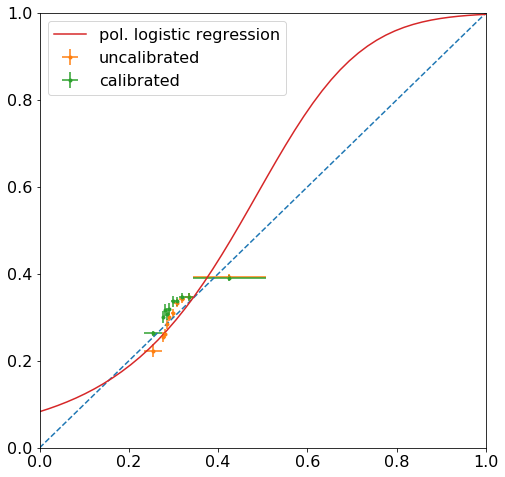

In [14]:
plt.figure(figsize=(8, 8))
plt.plot([0, 1], '--')
xs = np.linspace(0, 1)
plt.errorbar(*proba_bins(df.probas, df.target,
                         sample_weight=df.SigYield_sw,
                         auto_fill=True, bins=np.percentile(df.probas, np.linspace(0, 100, 11))),
                         fmt='.', label='uncalibrated')
plt.errorbar(*proba_bins(df.calib_probas, df.target,
                         sample_weight=df.SigYield_sw,
                         auto_fill=True, bins=np.percentile(df.probas, np.linspace(0, 100, 11))),
                         fmt='.', label='calibrated')
plt.plot(xs, calibrationModel.predict_proba(xs.reshape(-1, 1))[:,1], label='pol. logistic regression')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

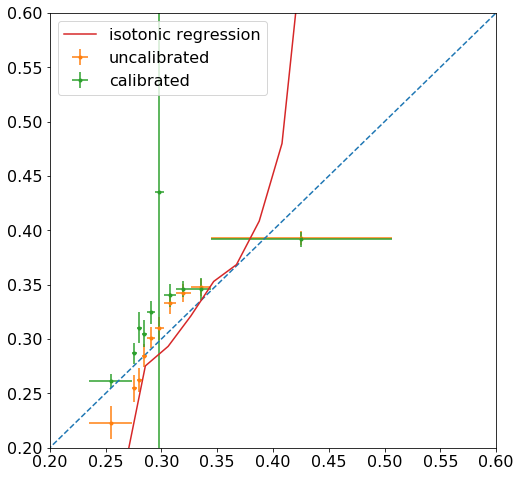

In [15]:
plt.figure(figsize=(8, 8))
plt.plot([0, 1], '--')
xs = np.linspace(0, 1)
plt.errorbar(*proba_bins(df.probas, df.target,
                         sample_weight=df.SigYield_sw,
                         auto_fill=True, bins=np.percentile(df.probas, np.linspace(0, 100, 11))),
                         fmt='.', label='uncalibrated')
plt.errorbar(*proba_bins(df.isotonic_probas, df.target,
                         sample_weight=df.SigYield_sw,
                         auto_fill=True, bins=np.percentile(df.probas, np.linspace(0, 100, 11))),
                         fmt='.', label='calibrated')
plt.plot(xs, isotonicModel.predict(xs), label='isotonic regression')
plt.xlim(0.2, 0.6)
plt.ylim(0.2, 0.6)
plt.legend(loc='best')
plt.show()

In [16]:
print(tagging_power_score(df.probas, tot_event_number=total_event_number, sample_weight=df.SigYield_sw) * 100,
      tagging_power_score(df.calib_probas, tot_event_number=total_event_number, sample_weight=df.SigYield_sw) * 100,
      )

1.0863+/-0.0011 1.1929+/-0.0012


In [17]:
df.etas = np.where(1 - df.probas > 0.5, df.probas, 1 - df.probas)

In [18]:
def calibration_curve(y_true, y_prob, bins=10):
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)

    if type(bins) is int:
        bins = np.linspace(0, 1, bins)
    else:
        bins = bins[:-1]

    binids = np.digitize(y_prob, bins)

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]
    
    return prob_true, prob_pred, (bin_sums[nonzero], bin_true[nonzero], bin_total[nonzero])

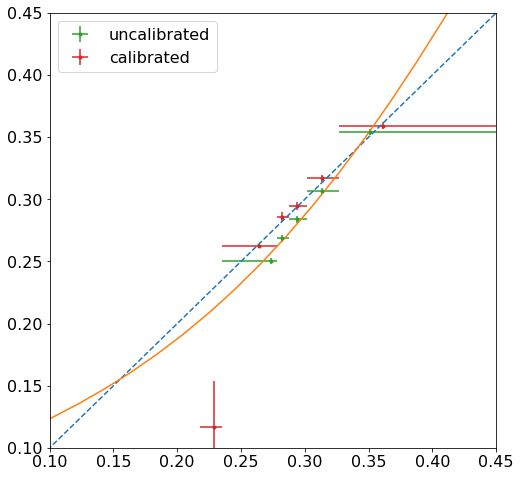

In [19]:
percents = np.linspace(0, 100, 6)
bins = np.percentile(df.probas, percents)
prob_true, prob_pred, (bin_sums, bin_true, bin_total) = calibration_curve(
    df.target, df.probas, bins=bins)
xerrs = [prob_pred - bins[:-1], bins[1:] - prob_pred]

plt.figure(figsize=(8, 8))
plt.plot([0, 1], '--')
xs = np.linspace(0, 1)
ys = calibrationModel.predict_proba(xs)[:, 1]
plt.plot(xs, ys)
plt.errorbar(prob_pred,
             prob_true,
             np.sqrt(prob_true * (1 - prob_true) * bin_total) / bin_total,
             xerrs,
             '.',
             label='uncalibrated',
            )

bins = np.concatenate(([df.calib_probas.min()], bins, [df.calib_probas.max()]))
prob_true, prob_pred, (bin_sums, bin_true, bin_total) = calibration_curve(
    df.target, df.calib_probas, bins=bins)
xerrs = [prob_pred - bins[:-1], bins[1:] - prob_pred]

plt.errorbar(prob_pred,
             prob_true,
             np.sqrt(prob_true * (1 - prob_true) * bin_total) / bin_total,
             xerrs,
             '.',
             label='calibrated',
            )
plt.xlim(0.1, 0.45)
plt.ylim(0.1, 0.45)
plt.legend(loc='best')
plt.show()

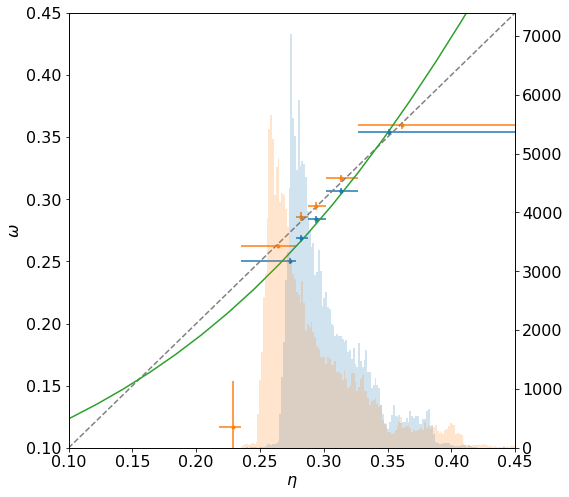

In [20]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

percents = np.linspace(0, 100, 6)
bins = np.percentile(df.etas, percents)
prob_true, prob_pred, (bin_sums, bin_true, bin_total) = calibration_curve(
    df.target, df.etas, bins=bins)
xerrs = [prob_pred - bins[:-1], bins[1:] - prob_pred]

_, ax1 = plt.subplots(figsize=(8, 8))
_, histbins = np.histogram(df.etas, bins='fd')
ax2 = ax1.twinx()
plt.hist(df.etas,
         bins=histbins,
         alpha=0.2,
         color=colors[0],
         )
xs = np.linspace(0, 1)
ys = calibrationModel.predict_proba(xs)[:, 1]

plt.sca(ax1)
plt.plot([0, 1], '--', color='grey')
plt.plot(xs, ys, color=colors[2])
plt.errorbar(prob_pred,
             prob_true,
             np.sqrt(prob_true * (1 - prob_true) * bin_total) / bin_total,
             xerrs,
             '.',
             label='uncalibrated',
             color=colors[0],
            )

bins = np.concatenate(([df.calib_etas.min()], bins, [df.calib_etas.max()]))
prob_true, prob_pred, (bin_sums, bin_true, bin_total) = calibration_curve(
    df.target, df.calib_etas, bins=bins)
xerrs = [prob_pred - bins[:-1], bins[1:] - prob_pred]

_, histbins = np.histogram(df.etas, bins='fd')
plt.sca(ax2)
plt.hist(df.calib_etas,
         bins=histbins,
         alpha=0.2,
         color=colors[1],
         )
plt.sca(ax1)

plt.errorbar(prob_pred,
             prob_true,
             np.sqrt(prob_true * (1 - prob_true) * bin_total) / bin_total,
             xerrs,
             '.',
             label='calibrated',
             color=colors[1],
            )
plt.xlim(0.1, 0.45)
plt.ylim(0.1, 0.45)
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\omega$')
plt.show()